# NOTEBOOK 2A - Feature Selection
### This script runs the optimisation algorithm
### The algorithm uses as input the predictor file and the target data in pat2k (extracted in notebook 1a and plotted in notebook 1b). 
### The algorithm runs a linear regression within the optimisation algorithm "wrapper", attempting different solutions at each evaluaiton and optimising the loss function (N-RMSE).
### Output: .csv with training and test skill scores, and corresponding solution files.

In [1]:
# import modules
from PyCROSL.CRO_SL import *
from PyCROSL.AbsObjectiveFunc import *
from PyCROSL.SubstrateReal import *
from PyCROSL.SubstrateInt import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import pandas as pd
import numpy as np
import xarray as xr

import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

import sys
sys.path.insert(1, '../Modules/')
from optimisation import optimisation

## STEP 1. FEATURE SELECTION SET-UP 
### Aim: Identify optimal combinations of potential predictors 
### Method: An optimization algorithm is used to test various combinations of predictors used to recreate the HW record.
### The algorithm optimizes the N-RMSE of validation period.

### Choose location

In [2]:
region="Cluj-Napoca"

### Choose the number of evaluations. In other words, how many optimisaiton attempts should be made?

In [3]:
eval_widget = widgets.IntSlider(
    value=200,                    # Default value
    min=150,                      # Minimum duration
    max=1000,                     # Maximum duration  
    step=50,                     # Step size
    description='Number of Evaluations:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

eval_widget

IntSlider(value=200, description='Number of Evaluations:', layout=Layout(width='400px'), max=1000, min=150, st…

## STEP 2 - LOAD AND CHECK PREDICTOR DATA.

In [4]:
num_eval=eval_widget.value
print ("Number of evaluations to run: ",num_eval)
first_train = "7002-04-30" # training period 1600 years #
last_train = "8600-04-30" # test period 250 years
first_test = last_train
last_test = "8851-04-30"

sol_data = pd.DataFrame(columns=['CV', 'Test', 'Sol'])
indiv_file = 'Output/optimisation_output.csv'
solution_file = 'Output/optimisation_output_sol.csv'
sol_data.to_csv(indiv_file, sep=' ', header=sol_data.columns, index=None)

pred_dataframe = pd.read_csv('Predictors_dataset_past2k_weekly-smallsample.csv', index_col=0)

Number of evaluations to run:  300


List of Potential Predictors
['mslpEurope_cluster1' 'mslpEurope_cluster2' 'mslpEurope_cluster3'
 'mslpEurope_cluster4' 'mslpEurope_cluster5' 'smEurope_cluster1'
 'smEurope_cluster2' 'smEurope_cluster3' 'smEurope_cluster4'
 'smEurope_cluster5' 'sstWorld_cluster1' 'sstWorld_cluster2'
 'sstWorld_cluster3' 'sstWorld_cluster4' 'sstWorld_cluster5'
 'sstMediterranean_cluster1' 'sstMediterranean_cluster2'
 'sstMediterranean_cluster3' 'sstMediterranean_cluster4'
 'sstMediterranean_cluster5' 'z500Europe_cluster1' 'z500Europe_cluster2'
 'z500Europe_cluster3' 'z500Europe_cluster4' 'z500Europe_cluster5'
 'olrTropics_cluster1' 'olrTropics_cluster2' 'olrTropics_cluster3'
 'olrTropics_cluster4' 'olrTropics_cluster5' 'tmaxEurope_cluster1'
 'tmaxEurope_cluster2' 'tmaxEurope_cluster3' 'tmaxEurope_cluster4'
 'tmaxEurope_cluster5' 'data_CO2' 'weekofyear']


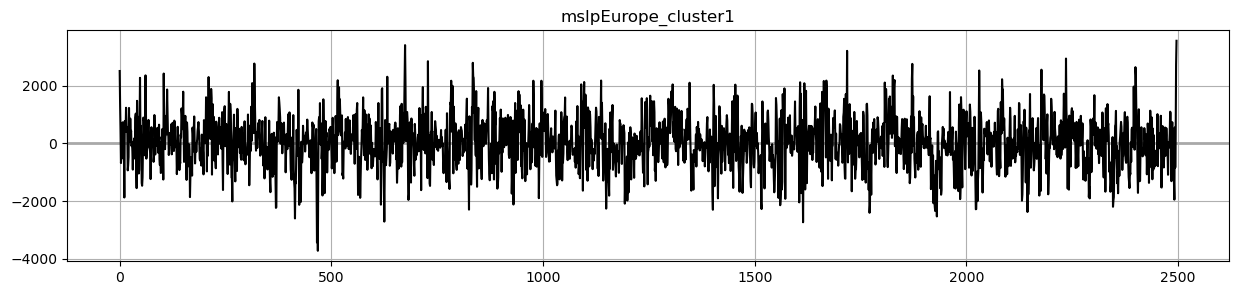

In [5]:
print ("List of Potential Predictors")
print (pred_dataframe.columns.values)

show_cluster="mslpEurope_cluster1"

plt.figure(figsize=(15,3))
plt.axhline(y=0,lw=2, c='darkgrey')
plt.plot(pred_dataframe[show_cluster]['8801-01-01':'8849-01-01'].values,'k-')
plt.grid()
plt.title(show_cluster)
plt.show()



## STEP 3 - Open Target Data.
### Record of NDQ90 in past2k.

In [6]:
df = pd.read_csv(f"Output/NumberHWdays_past2k_{region}_thresh90_dur3.csv")
print (df.NumberHWDays)

target_dates=[] # dummy date for target
train_years=range(7000,8850,1)

for year in train_years:
    target_dates.append(str(year).zfill(4)+"-04-30")

target_dates=target_dates

df_NDQ90=pd.DataFrame(df.NumberHWDays.values,columns=['Target'])
df_NDQ90.index = target_dates
target_dataset=df_NDQ90


first_train_index=int(np.argwhere(df_NDQ90.index==first_train))
last_train_index=int(np.argwhere(df_NDQ90.index==last_train))

0        2.0
1        4.0
2        1.0
3        2.0
4        2.0
        ... 
1845     9.0
1846     9.0
1847    30.0
1848     3.0
1849     1.0
Name: NumberHWDays, Length: 1850, dtype: float64


## STEP 4 - Run Optimisation Algorithm. 

In [7]:
# Initialize the objective function with size = 3 * number of predictors
objfunc = optimisation(
    size=3*pred_dataframe.shape[1],
    pred_dataframe=pred_dataframe,
    target_dataset=target_dataset,
    first_train_index=first_train_index,
    last_train_index=last_train_index,
    indiv_file=indiv_file
)

# Define CRO-SL parameters
params = {
    "popSize": 100,
    "rho": 0.6,
    "Fb": 0.98,
    "Fd": 0.2,
    "Pd": 0.8,
    "k": 3,
    "K": 20,
    "group_subs": True,

    "stop_cond": "Neval",
    "time_limit": 4000.0,
    "Ngen": 10000,
    "Neval": num_eval,
    "fit_target": 1000, 

    "verbose": True,
    "v_timer": 1,
    "Njobs": 1,

    "dynamic": True,
    "dyn_method": "success",
    "dyn_metric": "avg",
    "dyn_steps": 10,
    "prob_amp": 0.01
}

# Define operators for the algorithm
operators = [
    SubstrateInt("BLXalpha", {"F": 0.8}),
    SubstrateInt("Multipoint"),
    SubstrateInt("HS", {"F": 0.7, "Cr": 0.8, "Par": 0.2}),
    SubstrateInt("Xor"),
]

In [8]:
# Initialize and run the optimization algorithm
cro_alg = CRO_SL(objfunc, operators, params)
solution, obj_value = cro_alg.optimize()

# Save final solution
solution.tofile(solution_file, sep=',')
print(f"Optimization completed. Best objective value: {obj_value}")
print(f"Solution saved to {solution_file}")

Starting optimization of Some Function
--------------------------------------

1.0369610724373075 1.0083447624738622
1.0458429364613533 1.0255000057640151
1.0400697316542293 1.0155108281502747
1.0457331446069777 1.0144840946136189
1.0508202671339053 1.0514880329864
1.0319165820505298 1.007983123175689
1.0352847788750883 1.011501601987244
1.0318633779375106 1.016878159515595
1.0465860864515588 0.9809291389472365
1.04567724895464 1.0500698551455003
1.061750525066281 1.0226555473495311
1.040456652477715 1.0422535374193767
1.03823299561357 1.025343803662639
1.05059579911016 1.028271774711717
1.0436906278023421 1.0236139366415786
1.049477032890347 1.038031703866409
1.0523866633665273 1.0190168998710858
1.0506973680625868 1.0202733123451653
1.0422101140326094 1.040946679544824
1.041916179361295 1.0199775895750107
1.0388046705329281 1.0242507374685568
1.065674061965035 1.0193512162659502
1.0499519712876142 1.009263345602529
1.042946058502857 1.0111491601620897
1.0367060000168553 1.01058775690